In [1]:
%load_ext autoreload
%autoreload 2

In [92]:
import os
import rootutils

rootutils.setup_root(os.getcwd(), indicator=".project-root", pythonpath=True)

from torchvision import transforms
import torch
from src.data.components.graphs_datamodules import (
    IMCBaseDictTransform,
    PickleDataset,
    PatchAugmentations,
)
from src.data.imc_datamodule import add_channel
import src.data.components.graphs_datamodules as gd
from torchvision.datasets import MNIST
from torch.utils.data import ConcatDataset, Dataset, random_split

In [93]:
from pathlib import Path

In [94]:
from src.models.components.plot import restore_tensor
import matplotlib.pyplot as plt

base_transforms = IMCBaseDictTransform()

aug_transforms_train = gd.PatchAugmentations(
    prob=1.0,
    size=13,
    patch_size=1,
)

aug_transforms_val = gd.PatchAugmentations(
    prob=1.0,
    size=13,
    patch_size=1,
    is_validation=True,
)

dual_transforms_train = gd.DualOutputTransform(base_transforms, aug_transforms_train)

dual_transforms_val = gd.DualOutputTransform(base_transforms, aug_transforms_val)

train_path = Path("../data") / 'IMC-sample' / 'train.h5'
test_path = Path("../data") / 'IMC-sample' / 'test.h5'
trainset = PickleDataset(train_path, transform=dual_transforms_train)
testset = PickleDataset(train_path, transform=dual_transforms_val)
train_ratio, val_ratio, test_ratio, leftover_ratio = [3600, 1044, 0, 0]
size_testset = len(testset)
size_trainset = len(trainset)
data_train, _ = random_split(
    dataset=trainset,
    lengths=[train_ratio, size_trainset - train_ratio],
    generator=torch.Generator().manual_seed(42),
)
# dataset = ConcatDataset(datasets=[trainset, testset])
data_val, data_test, _ = random_split(
    dataset=testset,
    lengths=[val_ratio, test_ratio, size_testset - val_ratio - test_ratio],
    generator=torch.Generator().manual_seed(42),
)

train_dataset = gd.GridGraphDataset(grid_size=13, dataset=data_train, channels=list(range(10)))

train_loader = gd.DenseGraphDataLoader(
    dataset=train_dataset,
    batch_size=8,
    num_workers=7,
    pin_memory=False,
    persistent_workers=7 > 0,
)

In [95]:
for el in train_loader:
    print(el)
    break

In [96]:
el.node_features.shape

torch.Size([64, 169, 10])

In [97]:
# Import necessary modules for PLGraphAE
import os
import rootutils

rootutils.setup_root(os.getcwd(), indicator=".project-root", pythonpath=True)

import torch
import lightning as L
from omegaconf import DictConfig, OmegaConf
from src.models.pigvae_auto_module import PLGraphAE
from src.models.components.modules import GraphAE
from src.models.components.schedulers import TemperatureScheduler, EntropyWeightScheduler
from src.models.components.model import Critic
from src.data.components.graphs_datamodules import DenseGraphBatch


In [98]:
import yaml

# Path to your YAML config file
config_path = "../configs/model/model.yaml"

# Load the YAML file
with open(config_path, "r") as f:
    model_config_raw = yaml.safe_load(f)

print("Converting configurations to DictConfig...")

# Register custom OmegaConf resolvers for multiply and divide
from omegaconf import OmegaConf

# Register multiply resolver if not already registered
if not OmegaConf.has_resolver("multiply"):
    OmegaConf.register_new_resolver("multiply", lambda x, y: x * y)

# Register divide resolver if not already registered
if not OmegaConf.has_resolver("divide"):
    OmegaConf.register_new_resolver("divide", lambda x, y: x // y)

# Wrap the config under 'model' and 'data' keys so interpolations work
# Also provide the missing data.hparams.num_aug_per_sample value
full_config = OmegaConf.create({
    "model": model_config_raw,
    "data": {
        "hparams": {
            "num_aug_per_sample": 8,
            "batch_size": 8
        }
    },
    "trainer": {
        "max_epochs": 500,  # Set these to match your training config
        "min_epochs": 1
    }
})

# Now resolve all interpolations
OmegaConf.resolve(full_config)

print("Creating GraphAE from resolved config...")
graph_ae = GraphAE(hparams=full_config.model.graph_ae.hparams)
print("GraphAE created successfully!")

print("Creating schedulers...")
temperature_scheduler = TemperatureScheduler(hparams=full_config.model.temperature_scheduler.hparams)
entropy_weight_scheduler = EntropyWeightScheduler(hparams=full_config.model.entropy_weight_scheduler.hparams)

print("Creating critic...")
critic = Critic(hparams=full_config.model.critic.hparams)

print("Creating optimizer (dummy for loading)...")
# Create a dummy optimizer for loading (it will be overridden by the checkpoint)
optimizer = torch.optim.Adam(graph_ae.parameters(), lr=0.0001)

print("Creating scheduler (dummy for loading)...")
# Create a dummy scheduler for loading
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1)

print("All components created successfully!")


Converting configurations to DictConfig...
Creating GraphAE from resolved config...
GraphAE created successfully!
Creating schedulers...
Creating critic...
Creating optimizer (dummy for loading)...
Creating scheduler (dummy for loading)...
All components created successfully!


In [99]:
# Create the PLGraphAE model
print("Creating PLGraphAE model...")
model = PLGraphAE(
    graph_ae=graph_ae,
    critic=critic,
    temperature_scheduler=temperature_scheduler,
    entropy_weight_scheduler=entropy_weight_scheduler,
    optimizer=optimizer,
    scheduler=scheduler,
    compile=False
)

print("PLGraphAE model created successfully!")


Creating PLGraphAE model...
PLGraphAE model created successfully!


/Users/tomasznocon/Documents/MIM/Repositories/Master thesis/immuvis/.venv/lib/python3.12/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'critic' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['critic'])`.
/Users/tomasznocon/Documents/MIM/Repositories/Master thesis/immuvis/.venv/lib/python3.12/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'temperature_scheduler' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['temperature_scheduler'])`.
/Users/tomasznocon/Documents/MIM/Repositories/Master thesis/immuvis/.venv/lib/python3.12/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'entropy_weight_scheduler' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparame

In [100]:
# Load the checkpoint
checkpoint_path = "../logs/train/runs/2025-10-14_23-57-01/checkpoints/last.ckpt"



print(f"Loading checkpoint from: {checkpoint_path}")
print("This may take a moment...")

# Load the checkpoint with weights_only=False since this is a Lightning checkpoint
# that contains more than just weights (it's safe since this is our own trained model)
checkpoint = torch.load(checkpoint_path, map_location='mps', weights_only=False)
print("Checkpoint loaded successfully!")

# Load the state dict into the model
model.load_state_dict(checkpoint['state_dict'])
print("Model weights loaded successfully!")

# Set model to evaluation mode
model.eval()
print("Model is ready for inference!")


Loading checkpoint from: ../logs/train/runs/2025-10-14_23-57-01/checkpoints/last.ckpt
This may take a moment...
Checkpoint loaded successfully!
Model weights loaded successfully!
Model is ready for inference!


In [101]:
# Optional: Move model to GPU if available
device = 'mps'
model = model.to(device)
print(f"Model moved to device: {device}")

# Display model summary
print("\nModel loaded successfully!")
print(f"- Checkpoint epoch: {checkpoint.get('epoch', 'Unknown')}")
print(f"- Global step: {checkpoint.get('global_step', 'Unknown')}")
print(f"- Model device: {next(model.parameters()).device}")
print(f"- Model parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"- Trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")


Model moved to device: mps

Model loaded successfully!
- Checkpoint epoch: 499
- Global step: 510
- Model device: mps:0
- Model parameters: 18,023,049
- Trainable parameters: 18,022,921


In [102]:
from src.models.components.plot import restore_tensor
import matplotlib.pyplot as plt

base_transforms = IMCBaseDictTransform()

aug_transforms_train = gd.PatchAugmentations(
    prob=1.0,
    size=13,
    patch_size=1,
)

aug_transforms_val = gd.PatchAugmentations(
    prob=1.0,
    size=13,
    patch_size=1,
    is_validation=True,
)

dual_transforms_train = gd.DualOutputTransform(base_transforms, aug_transforms_train)

dual_transforms_val = gd.DualOutputTransform(base_transforms, aug_transforms_val)

train_path = Path("../data") / 'IMC-sample' / 'train.h5'
test_path = Path("../data") / 'IMC-sample' / 'test.h5'
trainset = PickleDataset(train_path, transform=dual_transforms_train)
testset = PickleDataset(train_path, transform=dual_transforms_val)
train_ratio, val_ratio, test_ratio, leftover_ratio = [3600, 1044, 0, 0]
size_testset = len(testset)
size_trainset = len(trainset)
data_train, _ = random_split(
    dataset=trainset,
    lengths=[train_ratio, size_trainset - train_ratio],
    generator=torch.Generator().manual_seed(42),
)
# dataset = ConcatDataset(datasets=[trainset, testset])
data_val, data_test, _ = random_split(
    dataset=testset,
    lengths=[val_ratio, test_ratio, size_testset - val_ratio - test_ratio],
    generator=torch.Generator().manual_seed(42),
)

train_dataset = gd.GridGraphDataset(grid_size=13, dataset=data_train, channels=list(range(1)))

val_dataset = gd.GridGraphDataset(grid_size=13, dataset=data_val, channels=list(range(1)))

train_loader = gd.DenseGraphDataLoader(
    dataset=train_dataset,
    batch_size=8,
    num_workers=7,
    pin_memory=False,
    persistent_workers=7 > 0,
)

val_loader = gd.DenseGraphDataLoader(
    dataset=val_dataset,
    batch_size=8,
    num_workers=7,
    pin_memory=False,
    persistent_workers=7 > 0,
)

In [104]:
for el in val_loader:
    break

In [105]:
el = el.to('mps')

In [106]:
model.eval()
with torch.no_grad():
    graph_emb, graph_pred, soft_probs, perm, mu, logvar = model(el, training=False, tau=1.0)

In [21]:
torch.allclose(graph_emb[0], graph_emb[16], atol=1e-4)

False

In [25]:
graph_emb[[0, 8, 16, 24, 32, 40, 48, 56]]

tensor([[-0.0884,  6.8511,  2.4379,  ..., -1.2252, -0.4291,  2.6785],
        [-0.0929,  6.8626,  2.4679,  ..., -1.2240, -0.4290,  2.6507],
        [-0.0929,  6.8626,  2.4679,  ..., -1.2240, -0.4290,  2.6507],
        ...,
        [-0.0929,  6.8626,  2.4679,  ..., -1.2240, -0.4290,  2.6507],
        [-0.0884,  6.8511,  2.4379,  ..., -1.2252, -0.4291,  2.6785],
        [-0.0929,  6.8626,  2.4679,  ..., -1.2240, -0.4290,  2.6507]],
       device='mps:0')

In [26]:
el.node_features.shape

torch.Size([64, 169, 1])

In [107]:
import src.models.components.metrics.recontructions as R
import src.models.components.plot as pL

idx_to_show = R.batch_augmented_indices(
            8, num_permutations=8, n_examples=4
        )
subset_predictions = graph_pred.node_features[idx_to_show, :, :]
subset_ground_truths = el.node_features[idx_to_show, :, :]

restore_subset_predictions = torch.stack(
            [img for img in subset_predictions], dim=0
        )
restore_subset_ground_truths = torch.stack(
            [img for img in subset_ground_truths],
            dim=0,
        )

ground_truth_imgs = restore_subset_ground_truths.detach().cpu()
pred_imgs = restore_subset_predictions.detach().cpu()
pred_min, pred_max = pred_imgs.min().item(), pred_imgs.max().item()
gt_min, gt_max = ground_truth_imgs.min().item(), ground_truth_imgs.max().item()

vmin = min(pred_min, gt_min)
vmax = max(pred_max, gt_max)


mse = R.mse_per_transform(ground_truth_imgs, pred_imgs, 4, 8)

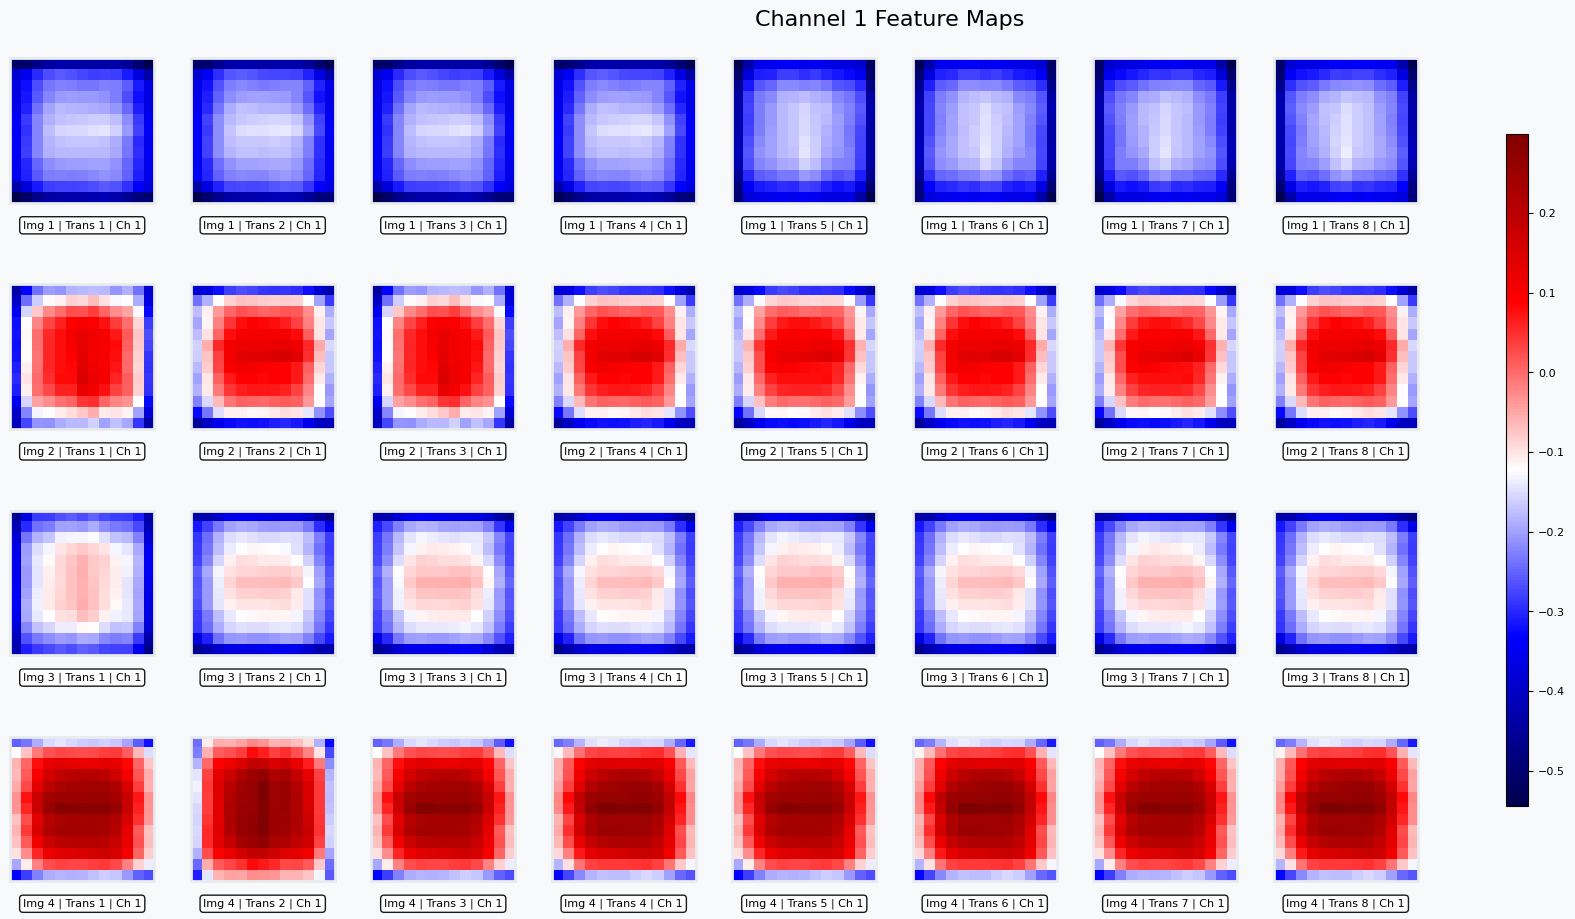

In [108]:
fig_prediction = pL.plot_feature_map(pred_imgs, 4, vmin=pred_min, vmax=pred_max)

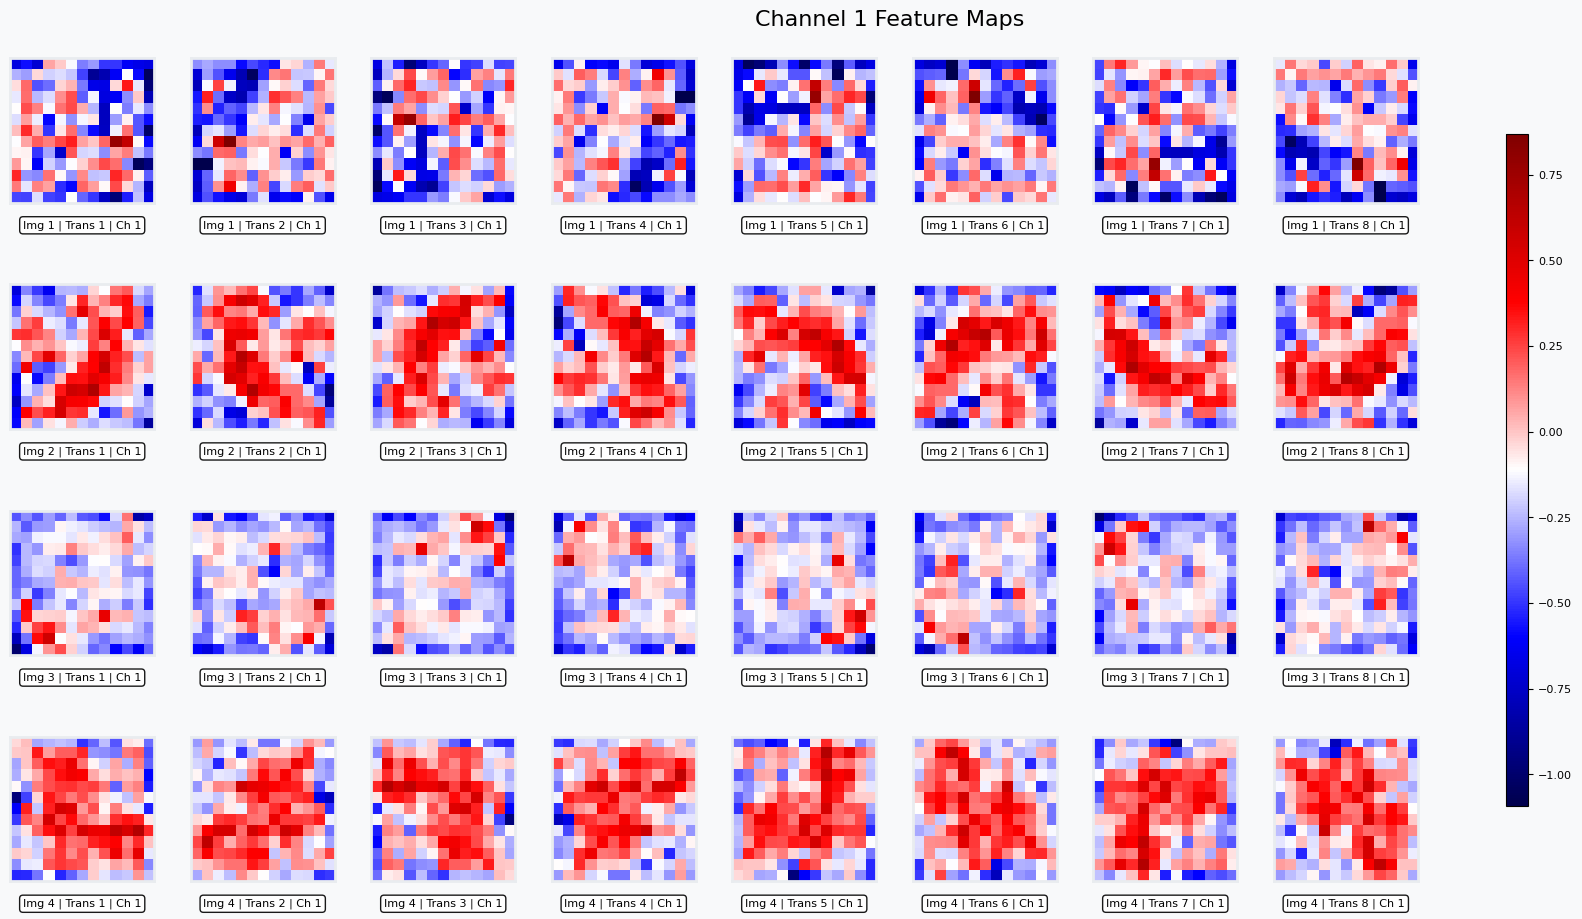

In [109]:
fig_ground_truth = pL.plot_feature_map(ground_truth_imgs, 4, vmin=vmin, vmax=vmax)

In [32]:
import math

def reshape_feature_map(features: torch.Tensor, num_example: int) -> torch.Tensor:
    batch_size, num_nodes, _ = features.shape
    grid_size = int(math.sqrt(num_nodes))
    group = int(batch_size // num_example)
    features = features.transpose(2, 1).view(batch_size, -1, grid_size, grid_size)
    return features.view(num_example, group, -1, grid_size, grid_size)

In [39]:
tensor_data_pred = reshape_feature_map(pred_imgs, 1)
tensor_data_truth = reshape_feature_map(ground_truth_imgs, 1)

In [43]:
tensor_data_pred[0][0]

tensor([[[-0.4447, -0.3361, -0.3188, -0.3145, -0.3081, -0.2991, -0.2853,
          -0.2831, -0.2910, -0.2979, -0.2996, -0.3871, -0.4890],
         [-0.4361, -0.2977, -0.2715, -0.2634, -0.2541, -0.2365, -0.2275,
          -0.2247, -0.2261, -0.2482, -0.2519, -0.3262, -0.4534],
         [-0.4021, -0.2495, -0.2148, -0.2061, -0.1883, -0.1690, -0.1580,
          -0.1568, -0.1606, -0.1926, -0.1994, -0.2624, -0.4136],
         [-0.3700, -0.2173, -0.1769, -0.1677, -0.1415, -0.1286, -0.1100,
          -0.1132, -0.1233, -0.1563, -0.1688, -0.2292, -0.3872],
         [-0.3582, -0.2072, -0.1650, -0.1506, -0.1235, -0.1149, -0.0917,
          -0.0994, -0.1121, -0.1407, -0.1645, -0.2223, -0.3793],
         [-0.3641, -0.2099, -0.1708, -0.1464, -0.1235, -0.1123, -0.0917,
          -0.0989, -0.1126, -0.1367, -0.1717, -0.2247, -0.3806],
         [-0.3748, -0.2149, -0.1801, -0.1476, -0.1269, -0.1115, -0.0944,
          -0.0997, -0.1139, -0.1357, -0.1745, -0.2246, -0.3801],
         [-0.3794, -0.2154, -0.182

In [42]:
tensor_data_truth[0][0]

tensor([[[-0.4663,  0.1451,  0.3097,  0.0859, -0.0940, -0.1115,  0.0159,
          -0.1722, -0.1068, -0.1562, -0.0426, -0.2638, -0.6784],
         [-0.4746, -0.1620, -0.3109, -0.0937, -0.0832,  0.0593,  0.3007,
           0.0748,  0.2300,  0.1717,  0.1742, -0.3024, -0.5765],
         [-0.1759,  0.1317, -0.3405, -0.6152, -0.4999,  0.1999,  0.0446,
          -0.1487,  0.1332, -0.2436, -0.4471, -0.0368, -0.7183],
         [-0.4731,  0.0723,  0.1599, -0.1963, -0.2828,  0.1357, -0.5012,
          -0.5866, -0.1234, -0.1779, -0.3876, -0.2026,  0.0603],
         [-0.5006, -0.5145, -0.0990, -0.3061, -0.7427,  0.2465, -0.0609,
          -0.1294,  0.1594,  0.1071, -0.0320, -0.1724, -0.0045],
         [-0.1034, -0.5898, -0.3121, -0.1163,  0.2146,  0.3225,  0.1715,
          -0.3196,  0.2398,  0.2269,  0.0282, -0.2198, -0.1213],
         [-0.4073,  0.1864,  0.1140, -0.0266, -0.1876,  0.0691, -0.3464,
          -0.1300,  0.0454, -0.4224, -0.3668, -0.4772, -0.3563],
         [-0.4959,  0.0776, -0.231

In [44]:
from torch.nn import MSELoss, L1Loss, CosineSimilarity

In [61]:
n = 1
MSELoss()(tensor_data_pred[0][n], tensor_data_truth[0][n])

tensor(0.0988)

In [62]:
L1Loss()(tensor_data_pred[0][n], tensor_data_truth[0][n])

tensor(0.2510)

In [65]:
CosineSimilarity()(tensor_data_pred[0][n], tensor_data_truth[0][n])

tensor([[0.9301, 0.6609, 0.5342, 0.4326, 0.7783, 0.7856, 0.7082, 0.6609, 0.4985,
         0.6053, 0.5931, 0.0374, 0.4325]])

In [67]:
tensor_data_truth[0][0].min(), tensor_data_truth[0][0].max()

(tensor(-1.0460), tensor(0.7728))

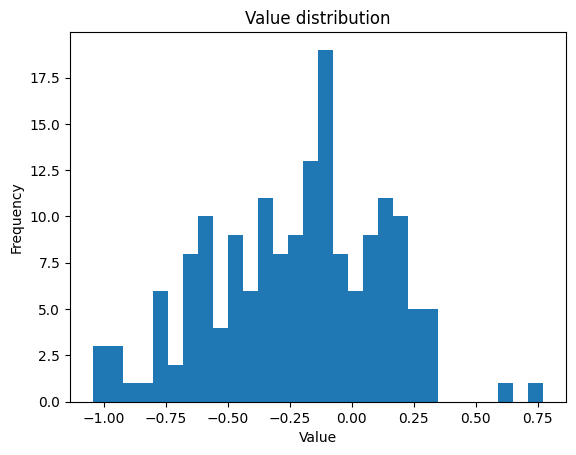

In [71]:
import torch
import matplotlib.pyplot as plt

x = tensor_data_truth[0][0][0].flatten()

plt.hist(x.numpy(), bins=30)
plt.title("Value distribution")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.show()


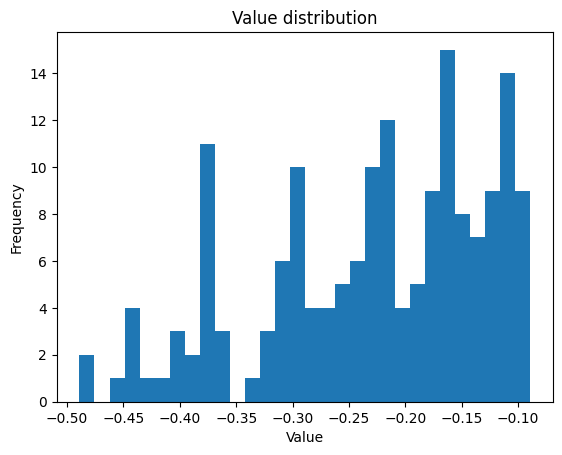

In [72]:
import torch
import matplotlib.pyplot as plt

x = tensor_data_pred[0][0][0].flatten()

plt.hist(x.numpy(), bins=30)
plt.title("Value distribution")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.show()


In [74]:
n = 1
mse = MSELoss()(tensor_data_pred[0][n], tensor_data_truth[0][n])

mse / tensor_data_truth[0][n].var()


tensor(0.9259)

In [77]:
ground_truth_imgs.shape

torch.Size([8, 169, 1])

In [78]:
graph_emb.shape

torch.Size([64, 1024])

In [137]:
import torch.nn as nn
from typing import Optional, Callable, Union, Tuple, List
from __future__ import annotations

class PatchAugmentations(nn.Module):
    NUM_PERM = 8  # 4 rotations × {no flip, flip}

    def __init__(
        self, prob: float, size: int, patch_size: int, is_validation: bool = False
    ):
        super().__init__()
        self.prob = prob
        self.is_validation = is_validation
        num_nodes_per_dim = size // patch_size
        self.register_buffer(
            "grid", self.make_grid(num_nodes_per_dim), persistent=False
        )

    def forward(
        self, patches: Dict[str, torch.Tensor]
    ) -> tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        """
        Args:
            patches: Dict[str, Tensor], each [C, N, D]
        Returns:
            aug_tensor: [8, C, N, D]
            argsort_tensor: [8, N]
            perm: [8] permutation used
        """
        device = self.grid.device
        grid = self.grid

        aug_list, argsort_list = [], []

        for transform_key, patch_embedding in patches.items():
            if transform_key == "img_path":
                continue

            # transformed_grid = self.apply_transform(grid, transform_key)
            transformed_grid = grid
            flat_idx = transformed_grid.flatten()

            aug_list.append(patch_embedding)  # or patch_embedding if already Tensor
            argsort_list.append(torch.argsort(flat_idx))

        aug_tensor = torch.stack(aug_list, dim=0).contiguous()
        argsort_tensor = torch.stack(argsort_list, dim=0).contiguous()

        if self.is_validation:
            perm = torch.arange(self.NUM_PERM, device=device)
            return aug_tensor, argsort_tensor, perm

        perm = torch.randperm(self.NUM_PERM, device=device)
        return aug_tensor, argsort_tensor, perm

    @staticmethod
    def make_grid(num_nodes_per_dim: int) -> torch.Tensor:
        """Create a 2D grid mapping flattened indices to 2D for rotation/flip operations."""
        return torch.arange(num_nodes_per_dim**2).reshape(
            num_nodes_per_dim, num_nodes_per_dim
        )

    @staticmethod
    def apply_transform(grid: torch.Tensor, key: str) -> torch.Tensor:
        """
        Apply rotation/flip based on key string (e.g. 'r90_f').
        """
        # Parse
        rot_part, flip_part = key.split("_")
        angle = int(rot_part[1:])  # 'r90' -> 90
        flip = flip_part == "f"

        # Apply rotation
        k = angle // 90
        out = torch.rot90(grid, k=k, dims=[0, 1]) if k > 0 else grid

        # Apply flip
        if flip:
            out = torch.flip(out, dims=[-1])

        return out

In [111]:
import pickle

class PickleDataset1(Dataset):
    def __init__(self, pickle_path, transform=None):
        self.transform = transform
        with open(pickle_path, "rb") as f:
            self.data = pickle.load(f)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        x = self.data[idx]
        if self.transform:
            x = self.transform(x)
        return x

In [140]:
pickle_path = "../data/IMC-sample/train.pkl"
pickle_path = "../data/IMC-sample/train.h5"

# pickle_dataset = PickleDataset1(pickle_path)
pickle_dataset = PickleDataset(pickle_path)

In [142]:
pickle_dataset.__getitem__(3).keys()

dict_keys(['r0_f', 'r0_nf', 'r180_f', 'r180_nf', 'r270_f', 'r270_nf', 'r90_f', 'r90_nf'])

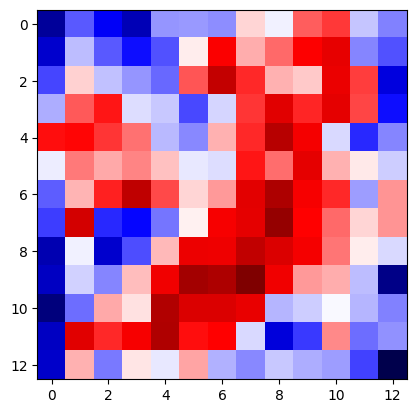

In [143]:
x = pickle_dataset.__getitem__(3)
plt.imshow(x['r0_f'][0], cmap="seismic", aspect="equal")

In [134]:
patch = PatchAugmentations(prob=1.0, size=13, patch_size=1)

grid =PatchAugmentations.make_grid(2)

In [139]:
PatchAugmentations.apply_transform(grid, 'r180_nf')

tensor([[3, 2],
        [1, 0]])

In [144]:
import torch
from typing import Tuple, Optional, Any
import torch.nn as nn
import torch.nn.functional as F

# from src.models.components.custom_graph_transformer import Transformer
from src.models.components.llama_graph_transformer import Transformer
from src.models.components.embeddings import PositionalEncoding
from src.data.components.graphs_datamodules import DenseGraphBatch
from src.models.components.spectral_embeddings import SklearnSpectralEmbedding
from src.models.components.rotary_embedding import LLamaRotaryEmbedding

from omegaconf import DictConfig


class SimplePermuter(torch.nn.Module):
    def __init__(self, hparams: DictConfig):
        super().__init__()
        self.turn_off = hparams.turn_off
        self.use_ce = hparams.use_ce
        self.scoring_fc = torch.nn.Linear(
            hparams.graph_decoder_hidden_dim, hparams.num_permutations
        )
        self.graph_transformer = Transformer(
            hidden_dim=hparams.graph_decoder_hidden_dim,
            num_heads=hparams.graph_decoder_num_heads,
            ppf_hidden_dim=hparams.graph_decoder_ppf_hidden_dim,
            num_layers=2,
            dropout=hparams.dropout,
            rope=LLamaRotaryEmbedding(hparams.head_dim)
        )
        self.perm_node = nn.Parameter(
            torch.randn(1, 1, hparams.graph_decoder_hidden_dim)
        )
        self.spectral_embeddings = SklearnSpectralEmbedding(
            hparams.n_components,
            hparams.graph_decoder_hidden_dim,
            hparams.grid_size,
        )
        self.perm_context = torch.nn.Linear(hparams.num_permutations, hparams.emb_dim)
        
        # Store grid_size for efficient permutation computation
        self.grid_size = hparams.grid_size
        self.num_permutations = hparams.num_permutations
        
        # Don't precompute large matrices - compute on demand
        # predefined_permutations = self.create_predefine_permutations(hparams.grid_size)
        # self.register_buffer("predefined_permutations", predefined_permutations)
        self.break_symmetry_scale = hparams.break_symmetry_scale

    def forward(
        self,
        node_features: torch.Tensor,
        tau: float,
        mask: torch.Tensor,
        hard: bool = False,
        labels: Optional[torch.Tensor] = None,
    ) -> Tuple[Optional[torch.Tensor], Any, Optional[torch.Tensor]]:
        device = node_features.device
        batch_size = node_features.shape[0] // 8

        if self.turn_off:
            # Use memory-efficient identity permutation
            n_nodes = self.grid_size * self.grid_size
            identity_perm = torch.eye(n_nodes, device=device, dtype=node_features.dtype)
            perm = identity_perm.unsqueeze(0).repeat(batch_size * 8, 1, 1)
            return perm, None, None, None

        # Add noise to break symmetry (reduce scale to save memory)
        noise_scale = min(self.break_symmetry_scale, 0.01)  # Cap noise to save memory
        node_features = (
            node_features + torch.randn_like(node_features) * noise_scale
        )
        
        # Clear intermediate tensors explicitly
        node_features = self.spectral_embeddings(node_features)
        cls_tokens = self.perm_node.expand(batch_size * 8, -1, -1)
        node_features = torch.cat([cls_tokens, node_features], dim=1)
        
        # Use gradient checkpointing for transformer
        node_features = self.graph_transformer(
            node_features, mask=None, is_encoder=True
        )
        
        # Score each permutation option
        cls_out = node_features[:, 0, :]
        scores = self.scoring_fc(cls_out)
        context = None

        # Cross-entropy loss
        ce_loss = None
        if self.use_ce and labels:
            labels = labels.to(device)
            ce_loss = F.cross_entropy(scores, labels)

        probs, soft_probs = softmax_head(scores, tau)

        # MEMORY-EFFICIENT PERMUTATION COMPUTATION
        # Instead of storing large matrices, compute permutations on-the-fly
        perm = self._compute_weighted_permutation_efficient(probs, device)
        
        return perm, context, soft_probs, ce_loss

    def _compute_weighted_permutation_efficient(self, probs, device):
        """
        Memory-efficient computation of weighted permutation matrices.
        Instead of storing all 8 large matrices, compute the result directly.
        """
        batch_size = probs.shape[0]
        n = self.grid_size
        n_nodes = n * n
        
        # Initialize result
        perm = torch.zeros(batch_size, n_nodes, n_nodes, device=device, dtype=probs.dtype)
        
        # Compute each permutation type contribution efficiently
        for perm_idx in range(8):  # 8 predefined permutations
            weight = probs[:, perm_idx].unsqueeze(-1).unsqueeze(-1)  # (B, 1, 1)
            
            if perm_idx == 0:  # Identity
                perm += weight * torch.eye(n_nodes, device=device, dtype=probs.dtype)
            elif perm_idx == 1:  # 90-degree rotation
                perm += weight * self._get_rotation_matrix_efficient(n, 1, device, probs.dtype)
            elif perm_idx == 2:  # 180-degree rotation
                perm += weight * self._get_rotation_matrix_efficient(n, 2, device, probs.dtype)
            elif perm_idx == 3:  # 270-degree rotation
                perm += weight * self._get_rotation_matrix_efficient(n, 3, device, probs.dtype)
            elif perm_idx == 4:  # Y-axis reflection
                perm += weight * self._get_reflection_matrix_efficient(n, device, probs.dtype)
            elif perm_idx == 5:  # Y-reflection + 90
                reflection = self._get_reflection_matrix_efficient(n, device, probs.dtype)
                rotation = self._get_rotation_matrix_efficient(n, 1, device, probs.dtype)
                perm += weight * torch.matmul(reflection, rotation)
            elif perm_idx == 6:  # Y-reflection + 180
                reflection = self._get_reflection_matrix_efficient(n, device, probs.dtype)
                rotation = self._get_rotation_matrix_efficient(n, 2, device, probs.dtype)
                perm += weight * torch.matmul(reflection, rotation)
            elif perm_idx == 7:  # Y-reflection + 270
                reflection = self._get_reflection_matrix_efficient(n, device, probs.dtype)
                rotation = self._get_rotation_matrix_efficient(n, 3, device, probs.dtype)
                perm += weight * torch.matmul(reflection, rotation)
        
        return perm

    def _get_rotation_matrix_efficient(self, n, num_rotations, device, dtype):
        """Generate rotation matrix efficiently without storing large intermediate tensors."""
        indices = torch.arange(n * n, device=device).reshape(n, n)
        for _ in range(num_rotations):
            indices = indices.rot90(-1)
        rotated_indices = indices.reshape(-1)
        return torch.eye(n * n, device=device, dtype=dtype)[rotated_indices]

    def _get_reflection_matrix_efficient(self, n, device, dtype):
        """Generate reflection matrix efficiently."""
        indices = torch.arange(n * n, device=device).reshape(n, n)
        reflected_indices = indices.flip(1).reshape(-1)
        return torch.eye(n * n, device=device, dtype=dtype)[reflected_indices]

    # Keep original methods for compatibility but don't use them
    def _permutation_matrix_90(self, n: int) -> torch.Tensor:
        indices = torch.arange(n * n).reshape(n, n)
        rotated_indices = indices.rot90(-1).reshape(-1)
        perm = torch.eye(n * n, dtype=torch.float32)[rotated_indices]
        return perm

    def _y_axis_reflection_matrix(self, n: int) -> torch.Tensor:
        indices = torch.arange(n * n).reshape(n, n)
        reflected_indices = indices.flip(1).reshape(-1)
        perm = torch.eye(n * n, dtype=torch.float32)[reflected_indices]
        return perm

    def create_predefine_permutations(self, n: int) -> torch.Tensor:
        """Keep for compatibility but don't use - too memory intensive."""
        perm = torch.eye(n * n, dtype=torch.float32)
        perm_90 = self._permutation_matrix_90(n)
        perm_180 = torch.matmul(perm_90, perm_90)
        perm_270 = torch.matmul(perm_180, perm_90)

        perm_y_reflection = self._y_axis_reflection_matrix(n)
        perm_y_reflection_90 = torch.matmul(perm_y_reflection, perm_90)
        perm_y_reflection_180 = torch.matmul(perm_y_reflection, perm_180)
        perm_y_reflection_270 = torch.matmul(perm_y_reflection, perm_270)

        permutations = torch.stack([
            perm, perm_90, perm_180, perm_270,
            perm_y_reflection, perm_y_reflection_90,
            perm_y_reflection_180, perm_y_reflection_270,
        ])
        return permutations

    @staticmethod
    def permute_node_features(
        node_features: torch.Tensor, perm: torch.Tensor
    ) -> torch.Tensor:
        """Apply the permutation to node features."""
        return torch.matmul(perm, node_features)

In [154]:
import networkx as nx

n = 4

n = int(math.sqrt(n))
G = nx.grid_2d_graph(n, n)
A = torch.tensor(nx.to_numpy_array(G), dtype=torch.bool)
# mask = A | torch.eye(A.shape[0], dtype=torch.bool)

In [155]:
A

tensor([[False,  True,  True, False],
        [ True, False, False,  True],
        [ True, False, False,  True],
        [False,  True,  True, False]])

In [164]:
mask = torch.tensor([[1, 1, 1, 1], [1, 1, 1, 1], [1, 1, 1, 1], [1, 1, 1, 1], [1, 1, 1, 1], [1, 1, 1, 1], [1, 1, 1, 1], [1, 1, 1, 1]])

In [165]:
attn_mask = mask.unsqueeze(2) & mask.unsqueeze(1)  # Logical AND for validity
attn_mask = attn_mask.to(device) if attn_mask.device != device else attn_mask